Gradiente Descendente Estocástico (Stochastic Gradient Descent)

- Atualizar os pesos a cada exemplo de treino (leia-se a cada cálculo com uma amostra do conjunto de treino).
- Implementação de um treinamento parcial 'partial-fit' que não reinicializa os pesos, que podemos utilizar para treinamento 'online'.
- Para verificar a convergência após o treinamento, vamos calcular o custo como a média dos custos em cada época.
- Funcionalidade para bagunçar os dados antes de cada época para evitar ciclos repetitivos com o random_state.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
class AdalineSGD(object):
    """Adaptive Linear Neuron classifier.

    Parameters
    ----------
    eta: float
        Learning rate (bwtween 0.0 and 1.0)
    n_iter: int
        Passes over the training dataset (number of epochs).
    shuffle: bool (default: True)
        Shuffles the training data every epoch if True to prevent cycles.
    random_state: int
        Random number generator seed for weight initialization.
    
    
    Attributes
    ----------
    w_: 1d-array
        Weights after fitting.
    cost_: list
        Sum-of-squares cost function value averaged over all training examples in each epoch.
    
    """

    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initializated = False
        self.shuffle = shuffle
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X: {array-like}, shape = [n_examples, n_features]
            Training vectors, where n_example is the number of examples and n_features is the number of features.
        y: array-like, shape = [n_examples]
            Target values.

        Returns
        -------
        self: object
        
        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []

            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        
        return self
    
    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initializated:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self
    
    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1+m)
        self.w_initializated = True
    
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        """Compute linear activation"""
        return X
    
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)


Teste de Implementação de um shuffle de dados simples

In [67]:
#CRIAÇÃO DOS DADOS DE TESTE
Xzao = np.array([[1, 1, 5], [2, 2, 6], [3, 3, 7]])
yzin = np.array([1, 2, 3])

#CONCATENANDO O ARRAY DE TARGET
result = np.column_stack((Xzao, yzin))
# result

#REALIZANDO A PERMUTAÇÃO COM O MÉTODO PERMUT DO np.random
result = np.random.permutation(result)
# result

#ATRIBUIÇÃO DOS DADOS COM SHUFFLE
Xzao = result[:, :-1]
yzin = result[:,-1]

print(Xzao)
print()
print(yzin)




[[3 3 7]
 [2 2 6]
 [1 1 5]]

[3 2 1]


In [75]:
list(zip(Xzao, yzin))

[(array([3, 3, 7]), np.int64(3)),
 (array([2, 2, 6]), np.int64(2)),
 (array([1, 1, 5]), np.int64(1))]

Importando os dados

In [9]:
#importando dados
df = pd.read_csv('Iris.csv', encoding='utf-8').drop('Id', axis=1)

#vamos utilizar apenas os atributos de comprimento da sépala e comprimento da pétala
X = df.iloc[:100, [0, 2]].values

#capturando setosa e verisculosa. setosa = -1; versiculosa = 1
y = df.iloc[:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

X_std = np.copy(X)
X_std[:,0] = ( X[:, 0] - X[:, 0].mean() ) / X[:, 0].std()
X_std[:,1] = ( X[:, 1] - X[:, 1].mean() ) / X[:, 1].std()

Treinamento e plotagem do modelo

In [8]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.02):

    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))

    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    #plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')    

C:\Users\ADM\AppData\Local\Temp\ipykernel_11832\1050011585.py:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl, 0],


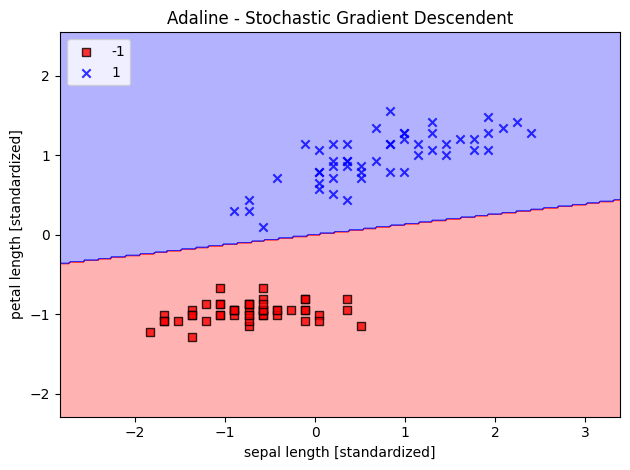

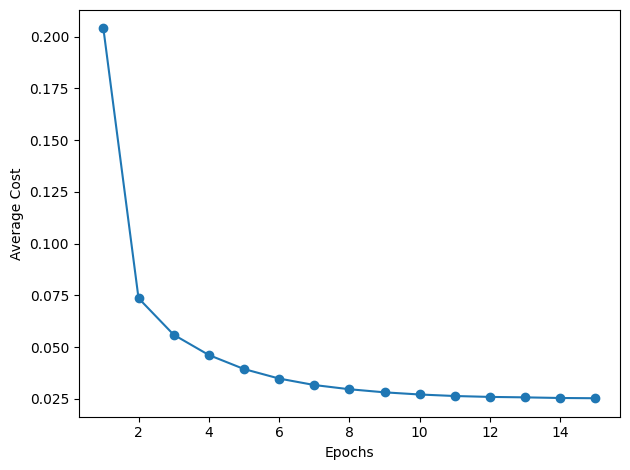

In [71]:
ada_sgd = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada_sgd.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada_sgd)
plt.title('Adaline - Stochastic Gradient Descendent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada_sgd.cost_) + 1), ada_sgd.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')
plt.tight_layout()
plt.show()
